# Battle of the Neighborhoods - Rehab Clinics

## Importing Modules and Defining Constants as Needed

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from geopy.geocoders import Nominatim
import requests
from pandas import json_normalize
from sklearn.cluster import KMeans

print('Libraries/Modules imported')

map_center = [53.287132, 9.139978]

print('Latitude and Logitude for centering map defined')

Libraries/Modules imported
Latitude and Logitude for centering map defined


## Defining Fourscare Credentials

In [2]:
CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
ACCESS_TOKEN = '...' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100

print('Credentials set; VERSION=20180604; LIMIT defined as', LIMIT)

Credentials set; VERSION=20180604; LIMIT defined as 100


## Defining Functions as Needed

### getNearbyVenues

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    print('working', end='')
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        print(' . ', end='')
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,                               # <== name of clinic
            v['venue']['name'],                 # <== name of the venue
            v['venue']['location']['distance'], # <== distance from clinic
            v['venue']['location']['lat'],      # <== latitude
            v['venue']['location']['lng'],      # <== longitude
            v['venue']['categories'][0]['name']) for v in results])

    print('done; write to results dataframe')
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Klinik', 
                  'Venue', 
                  'Venue Distance',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### return_most_common_venues

In [4]:
def return_most_common_venues(row_num, row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    results = row_categories_sorted.loc[lambda x : x>0].index.values[0:num_top_venues].tolist()
    num_venues = len(results)
    if num_venues < num_top_venues:
        for i in range(num_top_venues - num_venues):
            results.append('')
    
    return results

## List of Adresses of Rehabilitation Centers

### Importing from .csv to Dataframe

In [5]:
df_rehab = pd.read_csv('Klinikliste.csv', skiprows=1, sep=';')
print('This dataframe has', df_rehab.shape[0], 'rows')
print('','These are the first two rows:', sep='\n', end='')
display(df_rehab.head(2))

This dataframe has 60 rows

These are the first two rows:

Klinik                  Str_Hnr    PLZ  \
0                    Waldklinik Jesteburg       Kleckerwaldweg 145  21266   
1  Rehabilitations-Zentrum Oldenburg GmbH  Brandenburger Straße 31  26133   

         Ort  
0  Jesteburg  
1  Oldenburg

#### A Quick Look at Statistics per Column

In [6]:
display(df_rehab.describe(include='all'))

Klinik    Str_Hnr           PLZ       Ort
count                             60         60     60.000000        60
unique                            59         60           NaN        60
top     Friesenhörn-Nordsee-Kliniken  Kolkweg 1           NaN  Hannover
freq                               2          1           NaN         1
mean                             NaN        NaN  29745.033333       NaN
std                              NaN        NaN   7502.026556       NaN
min                              NaN        NaN  21266.000000       NaN
25%                              NaN        NaN  24386.250000       NaN
50%                              NaN        NaN  26449.500000       NaN
75%                              NaN        NaN  31733.250000       NaN
max                              NaN        NaN  49811.000000       NaN

### Adding Concatenated Address to Dataframe to Retrieve Latitude/Longitude Values

In [7]:
df_rehab['Address'] = df_rehab['Str_Hnr'] + ', ' + df_rehab['Ort'] + ', Deutschland'
display(df_rehab.head(2))

Klinik                  Str_Hnr    PLZ  \
0                    Waldklinik Jesteburg       Kleckerwaldweg 145  21266   
1  Rehabilitations-Zentrum Oldenburg GmbH  Brandenburger Straße 31  26133   

         Ort                                          Address  
0  Jesteburg       Kleckerwaldweg 145, Jesteburg, Deutschland  
1  Oldenburg  Brandenburger Straße 31, Oldenburg, Deutschland

## Longitudes and Latitudes

### Retrieving and Appending Longitudes and Latitudes

In [8]:
geolocator = Nominatim(user_agent='foursquare_agent')

latitudes, longitudes = [], []
print('working', end='')

for address in df_rehab['Address'].values:
    try:
        location = geolocator.geocode(address)
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    except:
        latitudes.append(np.nan)
        longitudes.append(np.nan)
    finally:
        print(' . ', end='')
        
print('done')

df_rehab['Latitude'] = latitudes
df_rehab['Longitude'] = longitudes
display(df_rehab.head())

working .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . done


Klinik                  Str_Hnr    PLZ  \
0                    Waldklinik Jesteburg       Kleckerwaldweg 145  21266   
1  Rehabilitations-Zentrum Oldenburg GmbH  Brandenburger Straße 31  26133   
2                    Reha-Zentrum am Meer      Unter den Eichen 18  26160   
3               Rehazentrum Wilhelmshaven         Bremer Straße 27  26382   
4                        Klinik Norddeich              Badestr. 15  26506   

                Ort                                            Address  \
0         Jesteburg         Kleckerwaldweg 145, Jesteburg, Deutschland   
1         Oldenburg    Brandenburger Straße 31, Oldenburg, Deutschland   
2   Bad Zwischenahn  Unter den Eichen 18, Bad Zwischenahn, Deutschland   
3     Wilhelmshaven       Bremer Straße 27, Wilhelmshaven, Deutschland   
4  Norden-Norddeich         Badestr. 15, Norden-Norddeich, Deutschland   

    Latitude  Longitude  
0  53.319612   9.949292  
1  53.114224   8.221676  
2  53.184796   8.021224  
3  53.524509   8.118236  
4  53.617254   7.153753

### Check for and Deal with Empty Values for Latitude/Longitude

In [9]:
df_nans = df_rehab[df_rehab['Latitude'].isna()]
display(df_nans)

Empty DataFrame
Columns: [Klinik, Str_Hnr, PLZ, Ort, Address, Latitude, Longitude]
Index: []

It seems that Geopy is not necessarily able to retrieve location data for valid addresses, so these rows would need to be dropped.

In this example, however, there are no problems. The code is still included in case other lists of clinics etc. are used.

In [10]:
print('Rows before dropping NaNs:', df_rehab.shape[0])
df_rehab.dropna(axis=0, inplace=True)
print('Rows after dropping NaNs:', df_rehab.shape[0])

Rows before dropping NaNs: 60
Rows after dropping NaNs: 60


#### Save Updated Dataframe to .csv (for Backup)

In [11]:
df_rehab.to_csv('df_rehab.csv', sep=';', index=False)
print('File saved')

File saved


### Check for Plausibility of Latitude/Longitude

In [12]:
print(df_rehab[['Latitude', 'Longitude']].min())
print(df_rehab[['Latitude', 'Longitude']].max())

Latitude     51.615529
Longitude     6.664696
dtype: float64
Latitude     54.941989
Longitude    11.205156
dtype: float64


Thes values seem to be well within the scope expected.

### Mark Rehabilitation Centers on Map

In [13]:
map_rehab = folium.Map(location=map_center, zoom_start=7,
                       tiles='https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}{r}.png', 
                       attr='wikimediafoundation.org')

for lat, lng, clinic, address in zip(df_rehab['Latitude'], df_rehab['Longitude'], 
                           df_rehab['Klinik'], df_rehab['Address']):
    label = str(clinic) + ', ' + str(address)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        weight=1,
        color='black',
        popup=label,
        fill = True,
        fill_color='darkblue',
        fill_opacity=1
    ).add_to(map_rehab)

# display map
print('Here is an overview of where the rehabilitation clinics are located:')
display(map_rehab)

Here is an overview of where the rehabilitation clinics are located:


*This is a screenshot of the map generated by the data. If you want to verify it's the same as the one generated, please plop the notebook into www.nbviewer.org. My computer is too old to run nbconvert as staff keeps suggesting.*

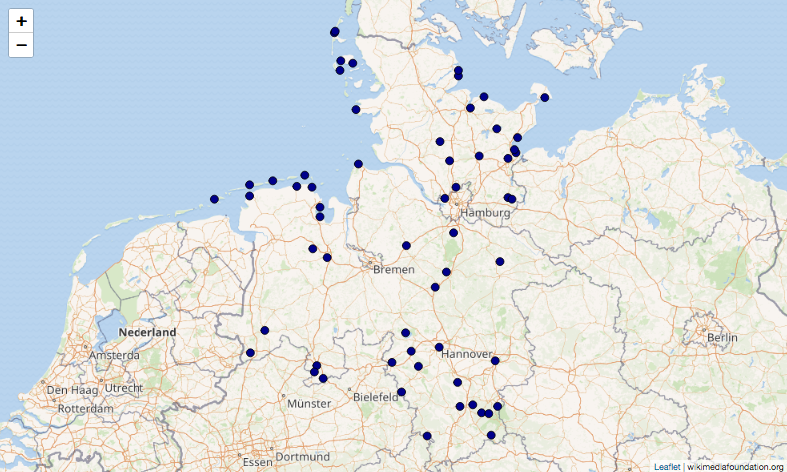

## Getting Venues for all Clinics

### Retrieve and Display Venue Data from Foursquare

In [14]:
df_venues = getNearbyVenues(df_rehab['Klinik'], 
                            df_rehab['Latitude'],
                            df_rehab['Longitude'], 
                            radius=5000)

print(' ')
print('There are', df_venues.shape[0], 'venues in total for all clinics')
display(df_venues.head(2))

working .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . done; write to results dataframe
 
There are 1767 venues in total for all clinics


Klinik              Venue  Venue Distance  Venue Latitude  \
0  Waldklinik Jesteburg  Landhaus Meinsbur            2705       53.341296   
1  Waldklinik Jesteburg               REWE            1452       53.306772   

   Venue Longitude Venue Category  
0         9.967656          Hotel  
1         9.945446    Supermarket

#### Save Dataframe to .csv (for Backup)

In [15]:
df_venues.to_csv('df_venues_orig.csv', sep=';', index=False)
print('File Saved')

File Saved


### Venue Categories

#### Complete List of Venues, Sorted Alphabetically

In [16]:
print('There are', df_venues['Venue Category'].nunique(), 'unique categories.')
print(sorted(df_venues['Venue Category'].unique()))

There are 221 unique categories.
['ATM', 'Accessories Store', 'Adult Boutique', 'Advertising Agency', 'Airport', 'Airport Terminal', 'American Restaurant', 'Aquarium', 'Asian Restaurant', 'Athletics & Sports', 'Automotive Shop', 'BBQ Joint', 'Baby Store', 'Bakery', 'Bank', 'Bar', 'Basketball Stadium', 'Beach', 'Beach Bar', 'Bed & Breakfast', 'Beer Bar', 'Beer Garden', 'Beer Store', 'Big Box Store', 'Bistro', 'Board Shop', 'Boarding House', 'Boat or Ferry', 'Bookstore', 'Botanical Garden', 'Boutique', 'Bowling Alley', 'Brazilian Restaurant', 'Breakfast Spot', 'Brewery', 'Building', 'Burger Joint', 'Bus Stop', 'Business Service', 'Cafeteria', 'Café', 'Campground', 'Canal Lock', 'Castle', 'Cave', 'Chinese Restaurant', 'Chocolate Shop', 'City Hall', 'Climbing Gym', 'Clothing Store', 'Cocktail Bar', 'Coffee Roaster', 'Coffee Shop', 'Comic Shop', 'Concert Hall', 'Construction & Landscaping', 'Creperie', 'Cupcake Shop', 'Currywurst Joint', 'Deli / Bodega', 'Department Store', 'Dessert Shop', 

## A Place to Stay for Visitors

### Filter Dataframe for Places to Stay

In [17]:
places_to_stay = ['Hotel', 'Hostel', 'Bed & Breakfast', 'Vacation Rental']
df_overnight = df_venues[df_venues['Venue Category'].isin(places_to_stay)]
print(df_overnight.shape[0], ' places to stay were found across all clinics.')
display(df_overnight.head())

115  places to stay were found across all clinics.


Klinik                   Venue  Venue Distance  \
0    Waldklinik Jesteburg       Landhaus Meinsbur            2705   
4    Waldklinik Jesteburg  Tagungshotel Jesteburg             819   
11   Waldklinik Jesteburg            Heidschnucke            3105   
110  Reha-Zentrum am Meer          Jagdhaus Eiden             816   
120  Reha-Zentrum am Meer       Seehotel Fährhaus             911   

     Venue Latitude  Venue Longitude Venue Category  
0         53.341296         9.967656          Hotel  
4         53.312378         9.947031          Hotel  
11        53.303284         9.987148          Hotel  
110       53.188487         8.031807          Hotel  
120       53.187102         8.008115          Hotel

### How many places to stay are there per clinic?

Out of 60 clinics 44 have a place to stay nearby.


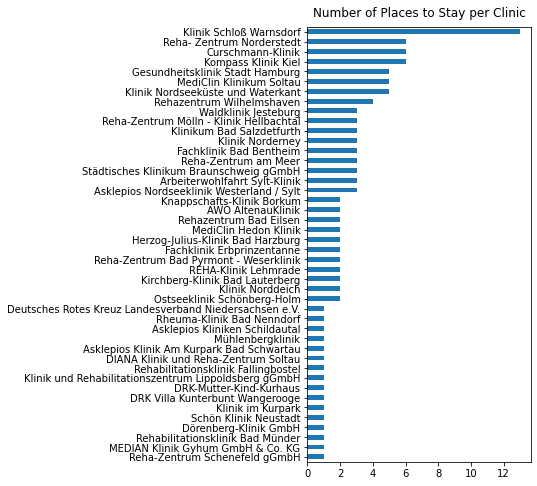

In [18]:
df_count_overnight = df_overnight['Klinik'].value_counts().to_frame(name='num of places to stay')
print('Out of 60 clinics', df_count_overnight.shape[0], 'have a place to stay nearby.')
fig, ax = plt.subplots(figsize=(4,8))
df_count_overnight.plot(kind='barh', figsize=(4, 8), legend=None, ax=ax)
ax.invert_yaxis()
plt.title('Number of Places to Stay per Clinic', y=1.01);

### Cluster by Availability of Places to Stay Nearby

In [19]:
df_rehab['Hotels Nearby'] = [True if place in df_count_overnight.index else False for place in df_rehab['Klinik']]
print(df_rehab.shape[0])
display(df_rehab.head())

60


Klinik                  Str_Hnr    PLZ  \
0                    Waldklinik Jesteburg       Kleckerwaldweg 145  21266   
1  Rehabilitations-Zentrum Oldenburg GmbH  Brandenburger Straße 31  26133   
2                    Reha-Zentrum am Meer      Unter den Eichen 18  26160   
3               Rehazentrum Wilhelmshaven         Bremer Straße 27  26382   
4                        Klinik Norddeich              Badestr. 15  26506   

                Ort                                            Address  \
0         Jesteburg         Kleckerwaldweg 145, Jesteburg, Deutschland   
1         Oldenburg    Brandenburger Straße 31, Oldenburg, Deutschland   
2   Bad Zwischenahn  Unter den Eichen 18, Bad Zwischenahn, Deutschland   
3     Wilhelmshaven       Bremer Straße 27, Wilhelmshaven, Deutschland   
4  Norden-Norddeich         Badestr. 15, Norden-Norddeich, Deutschland   

    Latitude  Longitude  Hotels Nearby  
0  53.319612   9.949292           True  
1  53.114224   8.221676          False  
2  53.184796   8.021224           True  
3  53.524509   8.118236           True  
4  53.617254   7.153753           True

### Visualize on Map

In [20]:
map_hotels = folium.Map(location=map_center, zoom_start=7,
                       tiles='https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}{r}.png', 
                       attr='wikimediafoundation.org')


for lat, lng, clinic, address, color in zip(df_rehab['Latitude'], df_rehab['Longitude'], 
                           df_rehab['Klinik'], df_rehab['Address'], df_rehab['Hotels Nearby']):
    label = str(clinic) + ', ' + str(address)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        weight=1,
        color='black',
        popup=label,
        fill = True,
        fill_color='darkgreen' if color == True else 'darkred',
        fill_opacity=1
    ).add_to(map_hotels)

# display map
print("Here is an overview of clinics that have/don't have places for visitors to stay nearby")
display(map_hotels)

Here is an overview of clinics that have/don't have places for visitors to stay nearby


*This is a screenshot of the map generated by the data. If you want to verify it's the same as the one generated, please plop the notebook into www.nbviewer.org. My computer is too old to run nbconvert as staff keeps suggesting.*

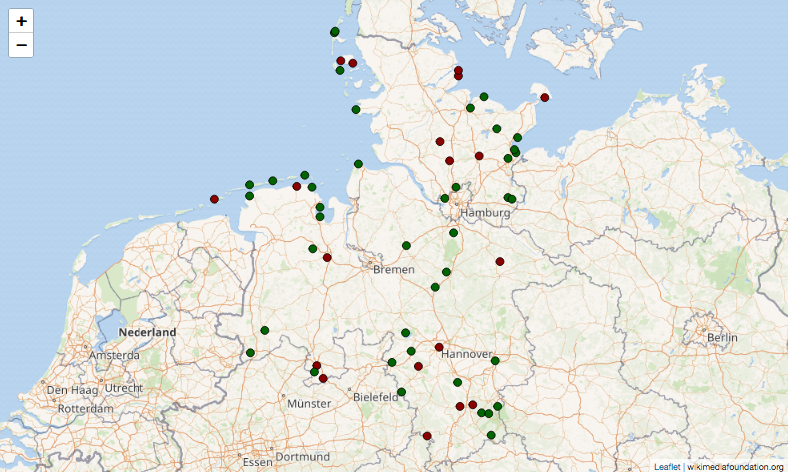

## A Place to Eat, aka Restaurants

### Get List of all Types of Restaurant

In [21]:
places_to_eat = []
for place in df_venues['Venue Category']:
    if 'Restaurant' in place:
        if not place in places_to_eat:
            places_to_eat.append(place)
places_to_eat.extend(['Steakhouse', 'Bistro', 'Trattoria/Osteria', 'Pizza Place',
                     'Burger Joint', 'BBQ Joint'])
print('There are', len(places_to_eat), 'different kinds of restaurants.')
print(places_to_eat)

There are 40 different kinds of restaurants.
['American Restaurant', 'Italian Restaurant', 'Middle Eastern Restaurant', 'Modern European Restaurant', 'German Restaurant', 'Vietnamese Restaurant', 'Spanish Restaurant', 'Sushi Restaurant', 'Restaurant', 'Doner Restaurant', 'Fast Food Restaurant', 'Greek Restaurant', 'Asian Restaurant', 'Seafood Restaurant', 'Grilled Meat Restaurant', 'Falafel Restaurant', 'Molecular Gastronomy Restaurant', 'Syrian Restaurant', 'Indian Restaurant', 'Turkish Restaurant', 'Mediterranean Restaurant', 'Russian Restaurant', 'French Restaurant', 'Mexican Restaurant', 'Halal Restaurant', 'Kebab Restaurant', 'Vegetarian / Vegan Restaurant', 'Eastern European Restaurant', 'Chinese Restaurant', 'Thai Restaurant', 'Japanese Restaurant', 'Brazilian Restaurant', 'North Indian Restaurant', 'Swiss Restaurant', 'Steakhouse', 'Bistro', 'Trattoria/Osteria', 'Pizza Place', 'Burger Joint', 'BBQ Joint']


### Filter Dataframe for Restaurants

In [22]:
df_restaurants = df_venues[df_venues['Venue Category'].isin(places_to_eat)]
print(df_restaurants.shape[0], 'restaurants were found across all clinics.')
display(df_restaurants.head())

466 restaurants were found across all clinics.


Klinik            Venue  Venue Distance  \
2                     Waldklinik Jesteburg            Lim's            4775   
10                    Waldklinik Jesteburg          Hübners            2568   
18  Rehabilitations-Zentrum Oldenburg GmbH           Mangal             614   
19  Rehabilitations-Zentrum Oldenburg GmbH  Osteria ROSSINI            2346   
28  Rehabilitations-Zentrum Oldenburg GmbH         Biggie B            2994   

    Venue Latitude  Venue Longitude             Venue Category  
2        53.327405         9.878667        American Restaurant  
10       53.341295         9.962481         Italian Restaurant  
18       53.114476         8.212490  Middle Eastern Restaurant  
19       53.132536         8.204277          Trattoria/Osteria  
28       53.140465         8.211798               Burger Joint

### What Types or Restaurants are there?

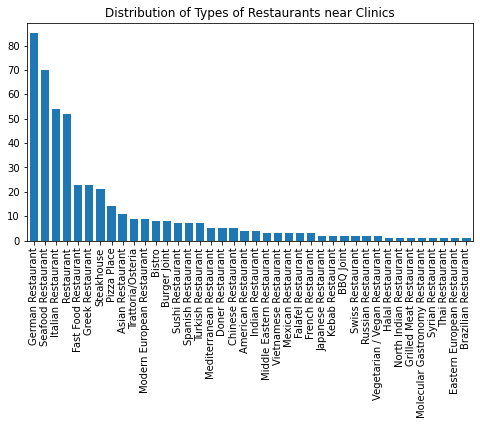

In [67]:
plt.figure(figsize=(8,4))
df_restaurants['Venue Category'].value_counts().plot(kind="bar", width=0.75)
plt.title('Distribution of Types of Restaurants near Clinics')
plt.savefig('Types of Restaurants.png', bbox_inches='tight');

### How Many Restaurants are Near Each Clinic?

Out of 60 clinics 54 have restaurants nearby.


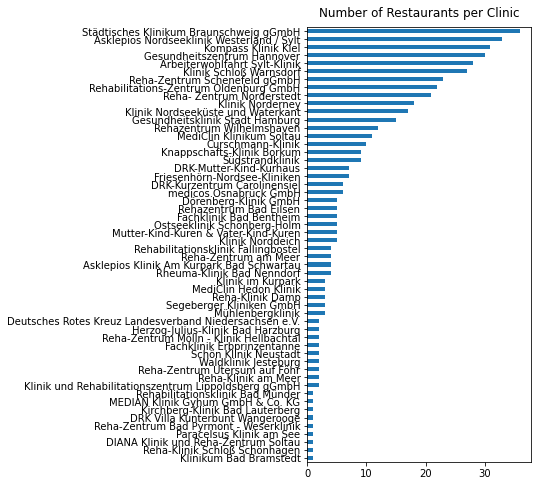

In [64]:
df_count_restaurants = df_restaurants['Klinik'].value_counts().to_frame(name='num of places to stay')
print('Out of 60 clinics', df_count_restaurants.shape[0], 'have restaurants nearby.')
fig, ax = plt.subplots(figsize=(4,8))
df_count_restaurants.plot(kind='barh', figsize=(4, 8), legend=None, ax=ax)
ax.invert_yaxis()
plt.title('Number of Restaurants per Clinic', y=1.01)
plt.savefig('Number of Restaurants per Clinic.png', bbox_inches='tight');

### Cluster by Availability of Restaurants Nearby

In [24]:
df_rehab['Restaurants Nearby'] = [True if place in df_count_restaurants.index else False for place in df_rehab['Klinik']]
print(df_rehab.shape[0])
display(df_rehab.head())

60


Klinik                  Str_Hnr    PLZ  \
0                    Waldklinik Jesteburg       Kleckerwaldweg 145  21266   
1  Rehabilitations-Zentrum Oldenburg GmbH  Brandenburger Straße 31  26133   
2                    Reha-Zentrum am Meer      Unter den Eichen 18  26160   
3               Rehazentrum Wilhelmshaven         Bremer Straße 27  26382   
4                        Klinik Norddeich              Badestr. 15  26506   

                Ort                                            Address  \
0         Jesteburg         Kleckerwaldweg 145, Jesteburg, Deutschland   
1         Oldenburg    Brandenburger Straße 31, Oldenburg, Deutschland   
2   Bad Zwischenahn  Unter den Eichen 18, Bad Zwischenahn, Deutschland   
3     Wilhelmshaven       Bremer Straße 27, Wilhelmshaven, Deutschland   
4  Norden-Norddeich         Badestr. 15, Norden-Norddeich, Deutschland   

    Latitude  Longitude  Hotels Nearby  Restaurants Nearby  
0  53.319612   9.949292           True                True  
1  53.114224   8.221676          False                True  
2  53.184796   8.021224           True                True  
3  53.524509   8.118236           True                True  
4  53.617254   7.153753           True                True

### Visualize on Map

In [68]:
map_restaurants = folium.Map(location=map_center, zoom_start=7,
                       tiles='https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}{r}.png', 
                       attr='wikimediafoundation.org')


for lat, lng, clinic, address, color in zip(df_rehab['Latitude'], df_rehab['Longitude'], 
                           df_rehab['Klinik'], df_rehab['Address'], df_rehab['Restaurants Nearby']):
    label = str(clinic) + ', ' + str(address)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        weight=1,
        color='black',
        popup=label,
        fill = True,
        fill_color='darkgreen' if color == True else 'darkred',
        fill_opacity=1
    ).add_to(map_restaurants)

# display map
print("Here is an overview of clinics that have/don't have restaurants to eat at nearby")
display(map_restaurants)

Here is an overview of clinics that have/don't have restaurants to eat at nearby


*This is a screenshot of the map generated by the data. If you want to verify it's the same as the one generated, please plop the notebook into www.nbviewer.org. My computer is too old to run nbconvert as staff keeps suggesting.*

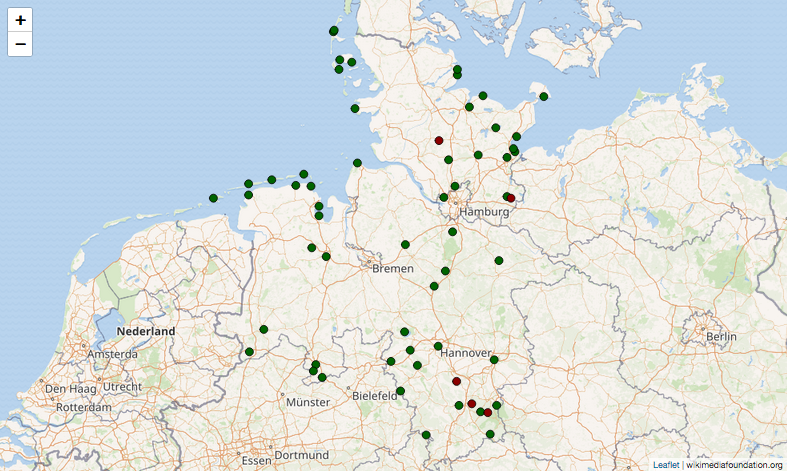

## Places to Visit or Take Visitors to

### Dropping Categories that are not of Interest

In [26]:
# categories that cannot be considered as attrations to visit or are places to stay
cat_for_drop = ['Rental Car Location', 'Train Station', 'Light Rail Station',
                'Airport', 'Airport Terminal', 'Gas Station', 'Intersection',
                'Insurance Office', 'Advertising Agency', 'Business Service',
                'Big Box Store', 'Train', 'City Hall', 'Military Base',
                'Construction & Landscaping', 'Truck Stop', 'Nightclub', 'ATM']
df_venues = df_venues[~df_venues['Venue Category'].isin(cat_for_drop)]

# all places to stay and restaurants
df_venues = df_venues[~df_venues['Venue Category'].isin(places_to_stay)]
df_venues = df_venues[~df_venues['Venue Category'].isin(places_to_eat)]
print('There are', df_venues['Venue Category'].nunique(), 'unique categories.')

There are 161 unique categories.


In [27]:
# supermarkets and food shops
places_food = ['Grocery Store', 'Food Court', 'Food & Drink Shop', 'Supermarket',
               'Bakery', 'Liquor Store']
df_venues = df_venues[~df_venues['Venue Category'].isin(places_food)]

# usually people don't want to spend time going to the big stores
stores = []
for place in df_venues['Venue Category']:
    if 'Store' in place:
        if not place in stores:
            stores.append(place)
stores.append('Drugstore')
df_venues = df_venues[~df_venues['Venue Category'].isin(stores)]

print('There are', df_venues['Venue Category'].nunique(), 'unique categories.')

There are 140 unique categories.


#### Save Updated Dataframe to .csv (for Backup)

In [28]:
df_venues.to_csv('df_venues_cleaned.csv', sep=';', index=False)
print('File Saved')

File Saved


### Are there Clinics with no Nearby Venues?

In [29]:
print('Number of Clinics:', df_venues['Klinik'].nunique(), end='\n\n')
print('Original Number of Clinics:', len(df_rehab['Klinik']), end='\n\n')

clinics_orig = sorted(df_rehab['Klinik'].to_list())
clinics_venues = sorted(df_venues['Klinik'].value_counts().index.to_list())
clinics_diff = []

diff_dict = {clinics_venues[i]: 0 for i in range(0, len(clinics_venues), 1)} 
for clinic in clinics_orig:
    if clinic in diff_dict:
        diff_dict[clinic] += 1
    else:
        clinics_diff.append(clinic)

for item in diff_dict.items():
    if item[1] > 1:
        clinics_diff.append(item[0])
        
print('These clinics do not have any interesting venues nearby:',
      '========================================================',
      clinics_diff, sep='\n')

Number of Clinics: 58

Original Number of Clinics: 60

These clinics do not have any interesting venues nearby:
['Asklepios Kliniken Schildautal', 'Friesenhörn-Nordsee-Kliniken']


### Venues per Clinic - Top and Bottom 5

In [30]:
print('Clinics with most venues:')
display(df_venues['Klinik'].value_counts().to_frame().head())
print('Clinics with least venues:')
display(df_venues['Klinik'].value_counts().to_frame().tail())

Clinics with most venues:


Klinik
Gesundheitszentrum Hannover                  56
Städtisches Klinikum Braunschweig gGmbH      53
MediClin Klinikum Soltau                     46
Klinik Schloß Warnsdorf                      44
Rehabilitations-Zentrum Oldenburg GmbH       39

Clinics with least venues:


Klinik
Reha-Klinik Damp                          2
Klinikum Bad Salzdetfurth                 1
REHA-Klinik Lehmrade                      1
Dörenberg-Klinik GmbH                     1
Rehabilitationsklinik Fallingbostel       1

### Venues for all Clinics
#### Top 50

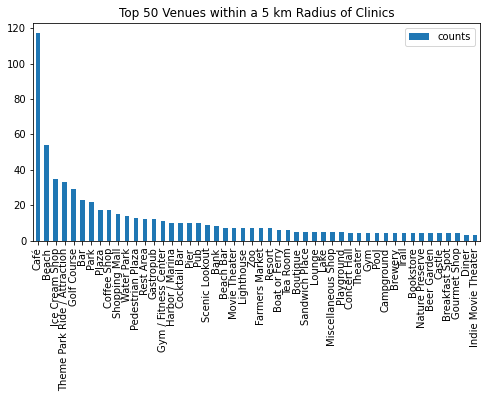

In [69]:
df_venue_counts = df_venues['Venue Category'].value_counts().to_frame(name='counts')
df_venue_counts.head(50).plot(kind='bar', figsize=(8,4))
plt.title('Top 50 Venues within a 5 km Radius of Clinics')
plt.savefig('Top 50 Venues Overall.png', bbox_inches='tight');

### Analysis of Neighbourhoods

In [32]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix='', prefix_sep='')

# add clinics column back to dataframe
df_onehot['Klinik'] = df_venues['Klinik'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

display(df_onehot.head())

Klinik  Adult Boutique  Aquarium  Athletics & Sports  \
3   Waldklinik Jesteburg               0         0                   0   
9   Waldklinik Jesteburg               0         0                   0   
12  Waldklinik Jesteburg               0         0                   0   
13  Waldklinik Jesteburg               0         0                   0   
14  Waldklinik Jesteburg               0         0                   0   

    Automotive Shop  Bank  Bar  Basketball Stadium  Beach  Beach Bar  ...  \
3                 0     0    0                   0      0          0  ...   
9                 0     0    0                   0      0          0  ...   
12                0     0    0                   0      0          0  ...   
13                0     0    0                   0      0          0  ...   
14                0     0    0                   0      0          0  ...   

    Tourist Information Center  Track  Trail  Tree  Water Park  Waterfront  \
3                            0      0      0     0           0           0   
9                            0      0      0     0           0           0   
12                           0      0      0     0           0           0   
13                           0      0      0     0           0           0   
14                           0      0      0     0           0           0   

    Wine Bar  Wine Shop  Zoo  Zoo Exhibit  
3          0          0    0            0  
9          0          0    0            0  
12         0          0    0            0  
13         0          0    0            0  
14         0          0    0            0  

[5 rows x 141 columns]

#### Group by Clinic using Sums

In [33]:
df_grouped = df_onehot.groupby('Klinik').sum().reset_index()
display(df_grouped.head(5))

Klinik  Adult Boutique  Aquarium  \
0                          AWO AltenauKlinik               0         0   
1              Arbeiterwohlfahrt Sylt-Klinik               0         0   
2  Asklepios Klinik Am Kurpark Bad Schwartau               0         0   
3  Asklepios Nordseeklinik Westerland / Sylt               0         0   
4                          Curschmann-Klinik               0         0   

   Athletics & Sports  Automotive Shop  Bank  Bar  Basketball Stadium  Beach  \
0                   0                0     0    0                   0      0   
1                   0                0     0    3                   0      5   
2                   0                0     0    0                   0      0   
3                   0                0     0    3                   0      5   
4                   0                0     0    1                   0      5   

   Beach Bar  ...  Tourist Information Center  Track  Trail  Tree  Water Park  \
0          0  ...                           0      0      0     0           0   
1          1  ...                           0      0      0     0           1   
2          0  ...                           0      0      0     0           1   
3          0  ...                           0      0      0     0           1   
4          0  ...                           0      0      0     0           0   

   Waterfront  Wine Bar  Wine Shop  Zoo  Zoo Exhibit  
0           0         0          0    0            0  
1           0         1          1    0            0  
2           0         0          0    0            0  
3           0         1          1    0            0  
4           0         0          0    1            0  

[5 rows x 141 columns]

#### Get Top 10 Venues for Later Display

In [34]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['Klinik']
for i in np.arange(num_top_venues):
    columns.append('Top {}'.format(i + 1))
    
df_top10_venues = pd.DataFrame(columns=columns)
df_top10_venues['Klinik'] = df_grouped['Klinik']

for row_num in np.arange(df_grouped.shape[0]):
    df_top10_venues.iloc[row_num, 1:] = return_most_common_venues(row_num, df_grouped.iloc[row_num, :], num_top_venues)

print(len(df_top10_venues), 'clinics have at least one venue nearby.')
display(df_top10_venues.head())

58 clinics have at least one venue nearby.


Klinik      Top 1         Top 2  \
0                          AWO AltenauKlinik  Reservoir  Cupcake Shop   
1              Arbeiterwohlfahrt Sylt-Klinik      Beach          Café   
2  Asklepios Klinik Am Kurpark Bad Schwartau       Café      Bus Stop   
3  Asklepios Nordseeklinik Westerland / Sylt       Café         Beach   
4                          Curschmann-Klinik       Café         Beach   

            Top 3           Top 4             Top 5            Top 6  \
0      Hot Spring                                                      
1             Bar     Golf Course    Scenic Lookout  Nature Preserve   
2  Ice Cream Shop            Park     Shopping Mall       Water Park   
3             Bar     Golf Course    Scenic Lookout         Tea Room   
4            Pier  Ice Cream Shop  Pedestrian Plaza              Zoo   

           Top 7            Top 8          Top 9              Top 10  
0                                                                     
1  National Park           Resort       Boutique         Snack Place  
2    Music Venue   Sandwich Place  Movie Theater                      
3  National Park  Nature Preserve       Boutique  Miscellaneous Shop  
4    Golf Course             Farm   Cocktail Bar           Bookstore

## Cluster Clinic Neighborhoods

### Use KMeans for Clustering

In [35]:
# set number of clusters
length = len(df_rehab)
kclusters = length // 4
print('number of clinics:', length, ', number of clusters:', kclusters, '\n')

df_grouped_clustering = df_grouped.drop('Klinik', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])

number of clinics: 60 , number of clusters: 15 

[ 1  4  5  4  6 14  5  1  5  5]


### Add Cluster Labels to Top 10 Venues and Merge with Clinics Information

In [36]:
# add clustering labels
df_top10_venues.insert(0, 'Cluster Labels', kmeans.labels_)

# merge clinic_grouped with clinic_data to add latitude/longitude for each neighborhood
df_merged = df_rehab.join(df_top10_venues.set_index('Klinik'), on='Klinik')

display(df_merged.head(2))

Klinik                  Str_Hnr    PLZ  \
0                    Waldklinik Jesteburg       Kleckerwaldweg 145  21266   
1  Rehabilitations-Zentrum Oldenburg GmbH  Brandenburger Straße 31  26133   

         Ort                                          Address   Latitude  \
0  Jesteburg       Kleckerwaldweg 145, Jesteburg, Deutschland  53.319612   
1  Oldenburg  Brandenburger Straße 31, Oldenburg, Deutschland  53.114224   

   Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels  \
0   9.949292           True                True             1.0   
1   8.221676          False                True            12.0   

            Top 1           Top 2         Top 3          Top 4        Top 5  \
0  Sandwich Place          Lounge  Climbing Gym  Shopping Mall          Gym   
1            Café  Ice Cream Shop         Plaza           Park  Coffee Shop   

  Top 6           Top 7      Top 8          Top 9    Top 10  
0                                                            
1   Bar  Farmers Market  Juice Bar  Movie Theater  Building

### Deal with Clinics with no Venues

In [37]:
df_merged[df_merged['Klinik'].isin(clinics_diff)]

Klinik             Str_Hnr    PLZ         Ort  \
24  Asklepios Kliniken Schildautal  Karl-Herold-Str. 1  38723      Seesen   
28    Friesenhörn-Nordsee-Kliniken     Möwenstraße 170  26434  Wangerland   
33    Friesenhörn-Nordsee-Kliniken  Dauenser Straße 19  26316       Varel   

                                     Address   Latitude  Longitude  \
24   Karl-Herold-Str. 1, Seesen, Deutschland  51.883028  10.216045   
28  Möwenstraße 170, Wangerland, Deutschland  53.692275   8.014521   
33    Dauenser Straße 19, Varel, Deutschland  53.448524   8.122934   

    Hotels Nearby  Restaurants Nearby  Cluster Labels  Top 1            Top 2  \
24           True               False             NaN    NaN              NaN   
28          False                True            13.0  Beach  Harbor / Marina   
33          False                True            13.0  Beach  Harbor / Marina   

             Top 3           Top 4         Top 5              Top 6  \
24             NaN             NaN           NaN                NaN   
28  Farmers Market  Ice Cream Shop  Cocktail Bar  Fish & Chips Shop   
33  Farmers Market  Ice Cream Shop  Cocktail Bar  Fish & Chips Shop   

          Top 7 Top 8 Top 9 Top 10  
24          NaN   NaN   NaN    NaN  
28  Event Space                     
33  Event Space

In [38]:
df_merged['Cluster Labels'].fillna(max(kmeans.labels_) + 1, inplace=True)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)
df_merged.head(2)

Klinik                  Str_Hnr    PLZ  \
0                    Waldklinik Jesteburg       Kleckerwaldweg 145  21266   
1  Rehabilitations-Zentrum Oldenburg GmbH  Brandenburger Straße 31  26133   

         Ort                                          Address   Latitude  \
0  Jesteburg       Kleckerwaldweg 145, Jesteburg, Deutschland  53.319612   
1  Oldenburg  Brandenburger Straße 31, Oldenburg, Deutschland  53.114224   

   Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels  \
0   9.949292           True                True               1   
1   8.221676          False                True              12   

            Top 1           Top 2         Top 3          Top 4        Top 5  \
0  Sandwich Place          Lounge  Climbing Gym  Shopping Mall          Gym   
1            Café  Ice Cream Shop         Plaza           Park  Coffee Shop   

  Top 6           Top 7      Top 8          Top 9    Top 10  
0                                                            
1   Bar  Farmers Market  Juice Bar  Movie Theater  Building

### Count Cluster Labels

In [39]:
display(df_merged['Cluster Labels'].value_counts()\
        .sort_index()\
        .to_frame(name='counts')\
        .transpose())

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
counts   2  17   1   1   2  12   2   1   1   3   1   1   1   4  10   1

### Show Clusters on Map

In [40]:
# create map
map_clusters = folium.Map(location=map_center, zoom_start=7,
                          tiles='https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}{r}.png', 
                          attr='wikimediafoundation.org')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, clinic, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], 
                                     df_merged['Klinik'], df_merged['Cluster Labels']):
    # add annotation to each marker
    map_clusters.add_child(folium.Marker([lat, lon], 
                                         icon=folium.DivIcon(icon_size=(0,0), 
                                                             icon_anchor=(0,0), 
                                                             html='<div style="font-size: 8pt; font-weight: bold">%s</div>' % cluster)))
    # label for popup
    label = folium.Popup(str(clinic) + ' Cluster ' + str(cluster), parse_html=True)
    
    # actual marker
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        weight=1,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
display(map_clusters)

*This is a screenshot of the map generated by the data. If you want to verify it's the same as the one generated, please plop the notebook into www.nbviewer.org. My computer is too old to run nbconvert as staff keeps suggesting.*

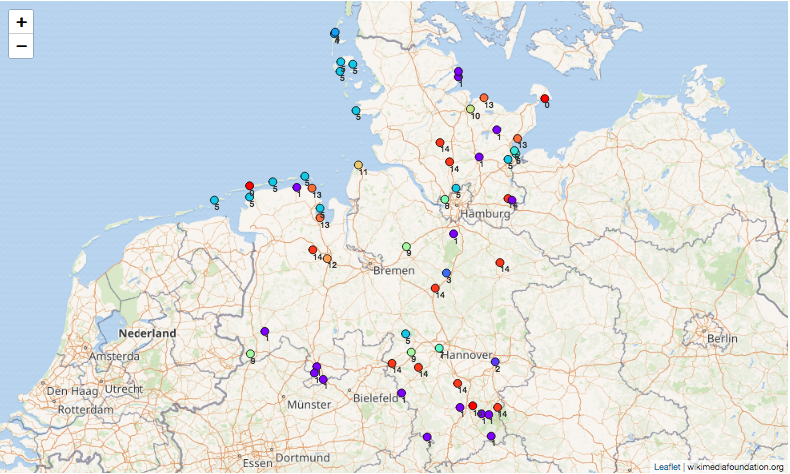

### Display Dataframes for each of the Clusters

In [41]:
for i in np.arange(kclusters):
    print('Cluster', i)
    display(df_merged[df_merged['Cluster Labels'] == i])

Cluster 0


Klinik             Str_Hnr    PLZ        Ort  \
5   Klinik Norderney     Kaiserstraße 26  26548  Norderney   
59   Südstrandklinik  Südstrandpromenade  23769   Fehmarn    

                                      Address   Latitude  Longitude  \
5     Kaiserstraße 26, Norderney, Deutschland  53.711090   7.147139   
59  Südstrandpromenade, Fehmarn , Deutschland  54.410252  11.205156   

    Hotels Nearby  Restaurants Nearby  Cluster Labels Top 1           Top 2  \
5            True                True               0  Café   Boat or Ferry   
59          False                True               0  Café  Ice Cream Shop   

         Top 3            Top 4        Top 5        Top 6       Top 7  \
5        Beach  Harbor / Marina  Coffee Shop  Golf Course        Park   
59  Campground      Golf Course       Museum     Aquarium  Water Park   

               Top 8          Top 9      Top 10  
5   Pedestrian Plaza  Deli / Bodega  Playground  
59    History Museum          Beach  Board Shop

Cluster 1


Klinik                 Str_Hnr  \
0                                Waldklinik Jesteburg      Kleckerwaldweg 145   
14             Reha-Zentrum Bad Pyrmont - Weserklinik           Schulstraße 2   
18                             medicos.Osnabrück GmbH       Weiden Straße 2-4   
19                              Dörenberg-Klinik GmbH          Am Kurgarten 7   
20                                  Klinik im Kurpark  Hannoversche Straße 33   
21                              MediClin Hedon Klinik            Hedonallee 1   
23                           Paracelsus Klinik am See              Dehneweg 6   
26                         Fachklinik Erbprinzentanne       Goslarsche Str 80   
27                    Kirchberg-Klinik Bad Lauterberg          Kirchberg 7-11   
31  Klinik und Rehabilitationszentrum Lippoldsberg...           Birkenallee 1   
32                                  AWO AltenauKlinik    An der Silberhütte 1   
36                       DRK-Kurzentrum Carolinensiel        Am Kurzentrum 4b   
40                                   Mühlenbergklinik         Frahmsallee 1-7   
43                                   Reha-Klinik Damp     Seute-Deern-Ring 30   
44                      Reha-Klinik Schloß Schönhagen          Schloßstraße 1   
51                           Segeberger Kliniken GmbH            Am Kurpark 1   
58                               REHA-Klinik Lehmrade       Gudower Straße 10   

      PLZ                      Ort  \
0   21266                Jesteburg   
14  31812              Bad Pyrmont   
18  49080                Osnabrück   
19  49186                Bad Iburg   
20  49214          Bad Rothenfelde   
21  49811                   Lingen   
23  37581          Bad Gandersheim   
26  38678     Clausthal-Zellerfeld   
27  37431   Bad Lauterberg im Harz   
31  34399                 Wesertal   
32  38707                  Altenau   
36  26409            Carolinensiel   
40  23714  Bad Malente-Gremsmühlen   
43  24351                    Damp    
44  24398               Schönhagen   
51  23795            Bad Segeberg    
58  23883                Lehmrade    

                                              Address   Latitude  Longitude  \
0          Kleckerwaldweg 145, Jesteburg, Deutschland  53.319612   9.949292   
14            Schulstraße 2, Bad Pyrmont, Deutschland  51.988970   9.244344   
18          Weiden Straße 2-4, Osnabrück, Deutschland  52.217605   8.070061   
19             Am Kurgarten 7, Bad Iburg, Deutschland  52.162822   8.037912   
20  Hannoversche Straße 33, Bad Rothenfelde, Deuts...  52.108230   8.164261   
21                  Hedonallee 1, Lingen, Deutschland  52.511985   7.358431   
23           Dehneweg 6, Bad Gandersheim, Deutschland  51.869137  10.042201   
26  Goslarsche Str 80, Clausthal-Zellerfeld, Deuts...  51.814683  10.334249   
27  Kirchberg 7-11, Bad Lauterberg im Harz, Deutsc...  51.626095  10.468725   
31               Birkenallee 1, Wesertal, Deutschland  51.615529   9.588955   
32         An der Silberhütte 1, Altenau, Deutschland  51.805867  10.436496   
36       Am Kurzentrum 4b, Carolinensiel, Deutschland  53.696450   7.800242   
40  Frahmsallee 1-7, Bad Malente-Gremsmühlen, Deut...  54.165057  10.550202   
43            Seute-Deern-Ring 30, Damp , Deutschland  54.585539  10.022216   
44            Schloßstraße 1, Schönhagen, Deutschland  54.631660  10.022348   
51           Am Kurpark 1, Bad Segeberg , Deutschland  53.943400  10.308132   
58          Gudower Straße 10, Lehmrade , Deutschland  53.592636  10.752029   

    Hotels Nearby  Restaurants Nearby  Cluster Labels                  Top 1  \
0            True                True               1         Sandwich Place   
14           True                True               1                    Zoo   
18          False                True               1          Bowling Alley   
19           True                True               1                 Castle   
20           True                True               1         Ice Cream Shop   


Cluster 2


Klinik         Str_Hnr    PLZ  \
25  Städtisches Klinikum Braunschweig gGmbH  Nîmesstrasse 1  38100   

             Ort                                    Address   Latitude  \
25  Braunschweig  Nîmesstrasse 1, Braunschweig, Deutschland  52.256839   

    Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels Top 1 Top 2  \
25  10.523072           True                True               2  Café  Park   

   Top 3        Top 4  Top 5      Top 6                 Top 7          Top 8  \
25   Bar  Coffee Shop  Plaza  Gastropub  Gym / Fitness Center  Shopping Mall   

           Top 9 Top 10  
25  Cocktail Bar    Pub

Cluster 3


Klinik          Str_Hnr    PLZ     Ort  \
8  MediClin Klinikum Soltau  Oeninger Weg 59  29614  Soltau   

                                Address   Latitude  Longitude  Hotels Nearby  \
8  Oeninger Weg 59, Soltau, Deutschland  52.994299   9.856789           True   

   Restaurants Nearby  Cluster Labels                         Top 1     Top 2  \
8                True               3  Theme Park Ride / Attraction  Boutique   

       Top 3        Top 4        Top 5        Top 6 Top 7    Top 8  \
8  Rest Area  Golf Course  Coffee Shop  Outlet Mall  Café  Brewery   

           Top 9      Top 10  
8  Bowling Alley  Theme Park

Cluster 4


Klinik          Str_Hnr    PLZ  \
48  Asklepios Nordseeklinik Westerland / Sylt  Norderstraße 81  25980   
57              Arbeiterwohlfahrt Sylt-Klinik         Osetal 7  25996   

             Ort                                   Address   Latitude  \
48    Westerland  Norderstraße 81, Westerland, Deutschland  54.925469   
57  Wenningstedt       Osetal 7, Wenningstedt, Deutschland  54.941989   

    Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels  Top 1  \
48   8.313285           True                True               4   Café   
57   8.327592           True                True               4  Beach   

    Top 2 Top 3        Top 4           Top 5            Top 6          Top 7  \
48  Beach   Bar  Golf Course  Scenic Lookout         Tea Room  National Park   
57   Café   Bar  Golf Course  Scenic Lookout  Nature Preserve  National Park   

              Top 8     Top 9              Top 10  
48  Nature Preserve  Boutique  Miscellaneous Shop  
57           Resort  Boutique         Snack Place

Cluster 5


Klinik               Str_Hnr  \
3                           Rehazentrum Wilhelmshaven      Bremer Straße 27   
4                                    Klinik Norddeich           Badestr. 15   
11  Deutsches Rotes Kreuz Landesverband Niedersach...  Rote-Kreuz-Straße 11   
22                         Knappschafts-Klinik Borkum  Böddinghausstraße 25   
34                            DRK-Mutter-Kind-Kurhaus     Süderdünenring 59   
35                    DRK Villa Kunterbunt Wangerooge   Siedlerstraße 48-50   
39          Asklepios Klinik Am Kurpark Bad Schwartau       Am Kurpark 6-12   
47                    Gesundheitsklinik Stadt Hamburg             Im Bad 35   
53                      Reha-Zentrum Utersum auf Föhr        Uaster Jügem 1   
54                                Reha-Klinik am Meer        Sandwall 25-27   
55               Mutter-Kind-Kuren & Vater-Kind-Kuren     Inselstraße 44 53   
56                          Reha- Zentrum Norderstedt     Stettiner Str. 16   

      PLZ                 Ort                                         Address  \
3   26382       Wilhelmshaven    Bremer Straße 27, Wilhelmshaven, Deutschland   
4   26506    Norden-Norddeich      Badestr. 15, Norden-Norddeich, Deutschland   
11  31535            Neustadt     Rote-Kreuz-Straße 11, Neustadt, Deutschland   
22  26757              Borkum       Böddinghausstraße 25, Borkum, Deutschland   
34  26465            Langeoog        Süderdünenring 59, Langeoog, Deutschland   
35  26486          Wangerooge    Siedlerstraße 48-50, Wangerooge, Deutschland   
39  23611       Bad Schwartau     Am Kurpark 6-12, Bad Schwartau, Deutschland   
47  25826  Sankt Peter-Ording      Im Bad 35, Sankt Peter-Ording, Deutschland   
53  25938             Utersum            Uaster Jügem 1, Utersum, Deutschland   
54  25938        Wyk auf Föhr       Sandwall 25-27, Wyk auf Föhr, Deutschland   
55  25940      Wittdün/Amrum   Inselstraße 44 53, Wittdün/Amrum , Deutschland   
56  22850         Norderstedt     Stettiner Str. 16, Norderstedt, Deutschland   

     Latitude  Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels  \
3   53.524509   8.118236           True                True               5   
4   53.617254   7.153753           True                True               5   
11  52.490050   9.299590           True                True               5   
22  53.594757   6.664696           True                True               5   
34  53.742019   7.471762           True                True               5   
35  53.788663   7.909066           True                True               5   
39  53.921594  10.699648           True                True               5   
47  54.314012   8.609053           True                True               5   
53  54.703915   8.401171          False                True               5   
54  54.685780   8.569019          False                True               5   
55  54.627676   8.396332          False                True               5   
56  53.689752   9.982889           True                True               5   

   Top 1           Top 2            Top 3        Top 4              Top 5  \
3   Café    Concert Hall        Multiplex         Pool                Pub   
4   Café           Beach      Zoo Exhibit   Water Park      Boat or Ferry   
11  Café            Lake            Beach  Golf Course             Castle   
22  Café     Snack Place       Lighthouse   Water Park               Food   
34  Café  Scenic Lookout   Ice Cream Shop        Beach                      
35  Café            Pier  Harbor / Marina        Beach  Fish & Chips Shop   
39  Café        Bus Stop   Ice Cream Shop         Park      Shopping Mall   
47  Café  Ice Cream Shop              Zoo   Water Park         Lighthouse   
53  Café           Beach                                                    
54  Café  Ice Cream Shop        Gastropub    Surf Spot              Beach   
55  Café      Lighthouse        Gastropub          Bar         Campground   
56  Café  Ice

Cluster 6


Klinik          Str_Hnr    PLZ                  Ort  \
49  Klinik Schloß Warnsdorf  Schloßstraße 10  23626           Warnsdorf    
50        Curschmann-Klinik      Saunaring 6  23669  Timmendorfer Strand   

                                          Address   Latitude  Longitude  \
49       Schloßstraße 10, Warnsdorf , Deutschland  53.967724  10.808809   
50  Saunaring 6, Timmendorfer Strand, Deutschland  53.997631  10.783223   

    Hotels Nearby  Restaurants Nearby  Cluster Labels Top 1  Top 2  \
49           True                True               6  Café  Beach   
50           True                True               6  Café  Beach   

             Top 3             Top 4             Top 5 Top 6           Top 7  \
49  Ice Cream Shop  Pedestrian Plaza              Pier  Bank  Breakfast Spot   
50            Pier    Ice Cream Shop  Pedestrian Plaza   Zoo     Golf Course   

     Top 8         Top 9        Top 10  
49  Lounge     Bookstore  Cocktail Bar  
50    Farm  Cocktail Bar     Bookstore

Cluster 7


Klinik              Str_Hnr    PLZ       Ort  \
9  Gesundheitszentrum Hannover  Kestnerstraße 42-43  30159  Hannover   

                                      Address   Latitude  Longitude  \
9  Kestnerstraße 42-43, Hannover, Deutschland  52.371383   9.756392   

   Hotels Nearby  Restaurants Nearby  Cluster Labels Top 1        Top 2  \
9          False                True               7  Café  Coffee Shop   

   Top 3 Top 4 Top 5 Top 6        Top 7        Top 8           Top 9  \
9  Plaza  Park   Bar   Pub  Salad Place  Zoo Exhibit  Ice Cream Shop   

      Top 10  
9  Irish Pub

Cluster 8


Klinik       Str_Hnr    PLZ         Ort  \
38  Reha-Zentrum Schenefeld gGmbH  Kiebitzweg 2  22869  Schenefeld   

                                  Address   Latitude  Longitude  \
38  Kiebitzweg 2, Schenefeld, Deutschland  53.601735   9.836397   

    Hotels Nearby  Restaurants Nearby  Cluster Labels          Top 1  \
38           True                True               8  Shopping Mall   

             Top 2                 Top 3 Top 4 Top 5  Top 6    Top 7  \
38  Ice Cream Shop  Gym / Fitness Center  Bank  Pool  Plaza  Taverna   

       Top 8        Top 9        Top 10  
38  Tea Room  Coffee Shop  Cocktail Bar

Cluster 9


Klinik                  Str_Hnr    PLZ  \
6   MEDIAN Klinik Gyhum GmbH & Co. KG  Alfred-Kettner-Straße 1  27404   
12         Rheuma-Klinik Bad Nenndorf          Bahnhofstraße 9  31542   
17            Fachklinik Bad Bentheim                Am Bade 1  48455   

             Ort                                      Address   Latitude  \
6          Gyhum  Alfred-Kettner-Straße 1, Gyhum, Deutschland  53.214955   
12  Bad Nenndorf   Bahnhofstraße 9, Bad Nenndorf, Deutschland  52.335534   
17  Bad Bentheim         Am Bade 1, Bad Bentheim, Deutschland  52.319475   

    Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels      Top 1  \
6    9.303508           True                True               9  Rest Area   
12   9.372443           True                True               9  Rest Area   
17   7.165007           True                True               9     Resort   

             Top 2               Top 3      Top 4       Top 5  \
6   Sandwich Place  Miscellaneous Shop  Gift Shop       Diner   
12  Adult Boutique                Café    Stadium        Park   
17       Rest Area               Plaza     Castle  Water Park   

                 Top 6                Top 7 Top 8 Top 9 Top 10  
6   Photography Studio  Fried Chicken Joint                     
12           Gastropub  Fried Chicken Joint                     
17

Cluster 10


Klinik                Str_Hnr    PLZ    Ort  \
52  Kompass Klinik Kiel  Heikendorfer Weg 9-27  24149  Kiel    

                                      Address   Latitude  Longitude  \
52  Heikendorfer Weg 9-27, Kiel , Deutschland  54.328894  10.183811   

    Hotels Nearby  Restaurants Nearby  Cluster Labels Top 1  \
52           True                True              10  Café   

                   Top 2 Top 3        Top 4          Top 5        Top 6  \
52  Gym / Fitness Center   Bar  Coffee Shop  Movie Theater  Music Venue   

             Top 7       Top 8    Top 9          Top 10  
52  Farmers Market  Canal Lock  RV Park  Shopping Plaza

Cluster 11


Klinik                 Str_Hnr    PLZ  \
29  Klinik Nordseeküste und Waterkant  Hermann-Daur-Weg 21-25  27476   

         Ort                                        Address   Latitude  \
29  Cuxhaven  Hermann-Daur-Weg 21-25, Cuxhaven, Deutschland  53.880939   

    Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels  Top 1  \
29   8.647378           True                True              11  Beach   

             Top 2           Top 3      Top 4 Top 5          Top 6  \
29  Ice Cream Shop  Scenic Lookout  Beach Bar  Café  National Park   

         Top 7  Top 8   Top 9                 Top 10  
29  Water Park  Trail  Lounge  General Entertainment

Cluster 12


Klinik                  Str_Hnr    PLZ  \
1  Rehabilitations-Zentrum Oldenburg GmbH  Brandenburger Straße 31  26133   

         Ort                                          Address   Latitude  \
1  Oldenburg  Brandenburger Straße 31, Oldenburg, Deutschland  53.114224   

   Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels Top 1  \
1   8.221676          False                True              12  Café   

            Top 2  Top 3 Top 4        Top 5 Top 6           Top 7      Top 8  \
1  Ice Cream Shop  Plaza  Park  Coffee Shop   Bar  Farmers Market  Juice Bar   

           Top 9    Top 10  
1  Movie Theater  Building

Cluster 13


Klinik              Str_Hnr    PLZ  \
28  Friesenhörn-Nordsee-Kliniken      Möwenstraße 170  26434   
33  Friesenhörn-Nordsee-Kliniken   Dauenser Straße 19  26316   
37   Ostseeklinik Schönberg-Holm  An den Salzwiesen 1  24217   
41         Schön Klinik Neustadt    Am Kiebitzberg 10  23730   

                     Ort                                            Address  \
28            Wangerland           Möwenstraße 170, Wangerland, Deutschland   
33                 Varel             Dauenser Straße 19, Varel, Deutschland   
37  Schönberg (Holstein)  An den Salzwiesen 1, Schönberg (Holstein), Deu...   
41     Neustadt/Holstein  Am Kiebitzberg 10, Neustadt/Holstein, Deutschland   

     Latitude  Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels  \
28  53.692275   8.014521          False                True              13   
33  53.448524   8.122934          False                True              13   
37  54.417102  10.371353           True                True              13   
41  54.090329  10.829232           True                True              13   

    Top 1                         Top 2           Top 3           Top 4  \
28  Beach               Harbor / Marina  Farmers Market  Ice Cream Shop   
33  Beach               Harbor / Marina  Farmers Market  Ice Cream Shop   
37  Beach                     Gastropub            Pier            Café   
41  Beach  Theme Park Ride / Attraction       Gastropub           Plaza   

                         Top 5              Top 6        Top 7       Top 8  \
28                Cocktail Bar  Fish & Chips Shop  Event Space               
33                Cocktail Bar  Fish & Chips Shop  Event Space               
37  Tourist Information Center        Fish Market                            
41                        Café        Golf Course    Surf Spot  Theme Park   

                 Top 9 Top 10  
28                             
33                             
37                             
41  Athletics & Sports

Cluster 14


Klinik                    Str_Hnr    PLZ  \
2                      Reha-Zentrum am Meer        Unter den Eichen 18  26160   
7      DIANA Klinik und Reha-Zentrum Soltau     Dahlenburger Straße 2a  29549   
10                Klinikum Bad Salzdetfurth            An der Peesel 5  31162   
13                   Rehazentrum Bad Eilsen         Brunnenpromenade 2  31707   
15         Rehabilitationsklinik Bad Münder            Deisterallee 36  31848   
16        Herzog-Julius-Klinik Bad Harzburg        Kurhausstraße 13-17  38667   
30      Rehabilitationsklinik Fallingbostel                  Kolkweg 1  29683   
42  Reha-Zentrum Mölln - Klinik Hellbachtal  Sebastian-Kneipp-Straße 2  23879   
45                   Klinikum Bad Bramstedt  Oskar-Alexander-Straße 26  24576   
46                        Fachklinik Aukrug                  Tönsheide  24613   

                  Ort                                            Address  \
2     Bad Zwischenahn  Unter den Eichen 18, Bad Zwischenahn, Deutschland   
7        Bad Bevensen  Dahlenburger Straße 2a, Bad Bevensen, Deutschland   
10   Bad Salzdetfurth     An der Peesel 5, Bad Salzdetfurth, Deutschland   
13         Bad Eilsen        Brunnenpromenade 2, Bad Eilsen, Deutschland   
15         Bad Münder           Deisterallee 36, Bad Münder, Deutschland   
16       Bad Harzburg     Kurhausstraße 13-17, Bad Harzburg, Deutschland   
30  Bad Fallingbostel          Kolkweg 1, Bad Fallingbostel, Deutschland   
42             Mölln      Sebastian-Kneipp-Straße 2, Mölln , Deutschland   
45     Bad Bramstedt   Oskar-Alexander-Straße 26, Bad Bramstedt , Deu...   
46             Aukrug                     Tönsheide, Aukrug, Deutschland   

     Latitude  Longitude  Hotels Nearby  Restaurants Nearby  Cluster Labels  \
2   53.184796   8.021224           True                True              14   
7   53.081526  10.589336           True                True              14   
10  52.073760  10.012810           True               False              14   
13  52.243625   9.102583           True                True              14   
15  52.208175   9.473945           True                True              14   
16  51.872077  10.556533           True                True              14   
30  52.869028   9.705933           True                True              14   
42  53.608229  10.698668           True                True              14   
45  53.903627   9.893257          False                True              14   
46  54.059534   9.766492          False               False              14   

                 Top 1           Top 2            Top 3        Top 4  \
2       Ice Cream Shop            Food             Park  Flower Shop   
7          Golf Course      Hot Spring                                 
10         Golf Course                                                 
13         Golf Course            Park        Rest Area       Palace   
15         Golf Course  Scenic Lookout                                 
16            Mountain      Playground             Park    Gastropub   
30         Golf Course                                                 
42                 Pub           Plaza  Nature Preserve  Golf Course   
45         Golf Course                                                 
46  Miscellaneous Shop            Bank             Café  Golf Course   

            Top 5           Top 6        Top 7                  Top 8 Top 9  \
2            Tree            Café  Golf Course                                
7                                                                             
10                                                                            
13  Shopping Mall  Science Museum          Pub  Outdoors & Recreation         
15                                                                            
16           Café           Trail  Golf Course                                
30                                                                            
42           

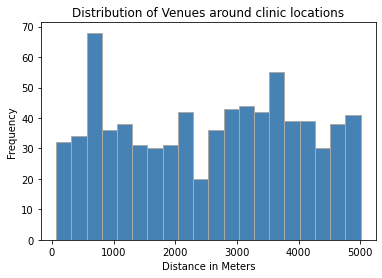

In [77]:
df_venues['Venue Distance'].plot(kind='hist', bins=20, ec='darkgray', color='steelblue')
plt.xlabel('Distance in Meters')
plt.title('Distribution of Venues around clinic locations')
plt.savefig('Histogram Venue Distribution.png', bbox_inches='tight');